# 生成对抗网络

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
epoch 0, D_loss: -0.026107442, G_loss: 0.033424523
epoch 1000, D_loss: -4.139182, G_loss: 0.02754787
epoch 2000, D_loss: -4.353203, G_loss: -0.25469333
epoch 3000, D_loss: -3.9520702, G_loss: -0.2129978
epoch 4000, D_loss: -3.904901, G_loss: -0.16549759


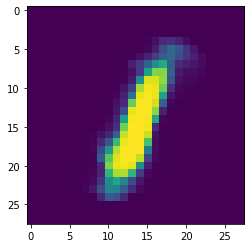

In [4]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

mnist = input_data.read_data_sets('./MNIST_data')

batch_size = 100
width,height = 28,28
mnist_dim = width*height
random_dim = 10
epochs = 5000

def my_init(size):
    return tf.random_uniform(size, -0.05, 0.05)

D_W1 = tf.Variable(my_init([mnist_dim, 128]))
D_b1 = tf.Variable(tf.zeros([128]))
D_W2 = tf.Variable(my_init([128, 32]))
D_b2 = tf.Variable(tf.zeros([32]))
D_W3 = tf.Variable(my_init([32, 1]))
D_b3 = tf.Variable(tf.zeros([1]))
D_variables = [D_W1, D_b1, D_W2, D_b2, D_W3, D_b3]

G_W1 = tf.Variable(my_init([random_dim, 32]))
G_b1 = tf.Variable(tf.zeros([32]))
G_W2 = tf.Variable(my_init([32, 128]))
G_b2 = tf.Variable(tf.zeros([128]))
G_W3 = tf.Variable(my_init([128, mnist_dim]))
G_b3 = tf.Variable(tf.zeros([mnist_dim]))
G_variables = [G_W1, G_b1, G_W2, G_b2, G_W3, G_b3]

def D(X):
    X = tf.nn.relu(tf.matmul(X, D_W1) + D_b1)
    X = tf.nn.relu(tf.matmul(X, D_W2) + D_b2)
    X = tf.matmul(X, D_W3) + D_b3
    return X

def G(X):
    X = tf.nn.relu(tf.matmul(X, G_W1) + G_b1)
    X = tf.nn.relu(tf.matmul(X, G_W2) + G_b2)
    X = tf.nn.sigmoid(tf.matmul(X, G_W3) + G_b3)
    return X

real_X = tf.placeholder(tf.float32, shape=[batch_size, mnist_dim])
random_X = tf.placeholder(tf.float32, shape=[batch_size, random_dim])
random_Y = G(random_X)

eps = tf.random_uniform([batch_size, 1], minval=0., maxval=1.)
X_inter = eps*real_X + (1. - eps)*random_Y
grad = tf.gradients(D(X_inter), [X_inter])[0]
grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=1))
grad_pen = 10 * tf.reduce_mean(tf.nn.relu(grad_norm - 1.))

D_loss = tf.reduce_mean(D(real_X)) - tf.reduce_mean(D(random_Y)) + grad_pen
G_loss = tf.reduce_mean(D(random_Y))

D_solver = tf.train.AdamOptimizer(1e-4, 0.5).minimize(D_loss, var_list=D_variables)
G_solver = tf.train.AdamOptimizer(1e-4, 0.5).minimize(G_loss, var_list=G_variables)


sess = tf.Session()
sess.run(tf.global_variables_initializer())


for e in range(epochs):
    for i in range(5):
        real_batch_X,_ = mnist.train.next_batch(batch_size)
        random_batch_X = np.random.uniform(-1, 1, (batch_size, random_dim))
        _,D_loss_ = sess.run([D_solver,D_loss], feed_dict={real_X:real_batch_X, random_X:random_batch_X})
    random_batch_X = np.random.uniform(-1, 1, (batch_size, random_dim))
    _,G_loss_ = sess.run([G_solver,G_loss], feed_dict={random_X:random_batch_X})
    if e % 1000 == 0:
        print('epoch %s, D_loss: %s, G_loss: %s'%(e, D_loss_, G_loss_))
        n_rows = 6
        check_imgs = sess.run(random_Y, feed_dict={random_X:random_batch_X}).reshape((batch_size, width, height))[:n_rows*n_rows]
        for i in range(n_rows*n_rows):
            plt.imshow(check_imgs[i])

plt.show()